In [1]:
import xarray as xr
import os
import glob
import numpy as np
import warnings
import matplotlib.pyplot as plt
from dask.diagnostics import ProgressBar
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Dataset
Our dataset consists of ~10 simulations, each is 5-year long, with different perturbed parameters. As a first stage we consider only thetao (3D potential temperature) averaged monthly. We want to create a linear model which can predict the response development over time. We start by preprocessing data: i.e. conservatively coarsegraining data to the 3x3 grid. Later this data will be used to analyse temperature drift for various model runs.

## Read original grid information

In [2]:
param = xr.open_dataset('/home/pp2681/global-runs/data/ocean_static.nc').isel(time=0)

## Initialize horizontal coarsegraining

In [3]:
import xesmf as xe

coords_in = xr.Dataset()
coords_in['lon'] = param.geolon
coords_in['lat'] = param.geolat
coords_in['lon_b'] = param.geolon_c.pad({'yq':(1,0)}, mode='symmetric').pad({'xq':(1,0)}, mode='wrap').drop_vars({'xq','yq'})
coords_in['lat_b'] = param.geolat_c.pad({'yq':(1,0)}, mode='symmetric').pad({'xq':(1,0)}, mode='wrap').drop_vars({'xq','yq'})

# 3-degree grid
coords_out = xe.util.grid_global(3, 3)
regridder_conserv = xe.Regridder(coords_in, coords_out, "conservative_normed", ignore_degenerate=True, periodic=True, unmapped_to_nan=True)

def regrid(array):
    out = regridder_conserv(array)
    lon = out.lon[0,:].values
    lat = out.lat[:,0].values
    return out.drop_vars(['lon', 'lat']).rename({'x':'xh', 'y':'yh'}).assign_coords({'xh': lon, 'yh': lat})

## Apply horizontal and vertical coarsegraining

In [182]:
base_path = '/scratch/pp2681/mom6/OM4_SIS2/'
exp = 'unparameterized'
files = os.path.join(base_path,exp,'output','*ocean_month_z*')
ds = xr.open_mfdataset(files, chunks={'time':1})

thetao = ds.thetao
# Vertical coarsening
param['dz'] = xr.DataArray(np.diff(ds.z_i), dims='z_l')
param['mask_nan'] = xr.where(np.isnan(thetao.isel(time=0)),np.nan,1.)
thetao_coarse_vertical = ((param['dz']* thetao).coarsen({'z_l':3}, boundary='trim').sum() / (param['dz'] * param['mask_nan']).coarsen({'z_l':3}, boundary='trim').sum()).transpose('time','z_l',...)
# Horizontal coarsening
thetao_coarse = regrid(thetao_coarse_vertical)

## Create coarse grid metadata

In [210]:
# Horizontal coarse grid
param_coarse = xr.Dataset()

R = 6.371e+6 
# Zonal distance (dx) varies with latitude
param_coarse['dyt'] = R * np.deg2rad(np.diff(thetao_coarse.xh)[0])
param_coarse['dxt'] = np.cos(np.deg2rad(thetao_coarse.yh)) * param_coarse['dyt']
param_coarse['dz'] = (param['dz']).coarsen({'z_l':3}, boundary='trim').sum()
param_coarse['mask_nan'] = xr.where(np.isnan(thetao_coarse.isel(time=0)),np.nan,1.)

In [ ]:
param_coarse.transpose('z_l','yh','xh').to_netcdf('/scratch/pp2681/calibration/OM4-NIF-5-years/param.nc')

# Compare time series of averaged data

In [14]:
def ave3d(array, param):
    return (array * param.dxt * param.dyt * param.dz * param.mask_nan).sum(['xh','yh','z_l']) / (param.dxt * param.dyt * param.dz * param.mask_nan).sum(['xh','yh','z_l'])

In [196]:
from dask.diagnostics import ProgressBar
with ProgressBar():
    thetao_3d = ave3d(thetao, param).compute()

[########################################] | 100% Completed | 30.39 s


In [197]:
with ProgressBar():
    thetao_coarse_3d = ave3d(thetao_coarse, param_coarse).compute()

[########################################] | 100% Completed | 24.86 s


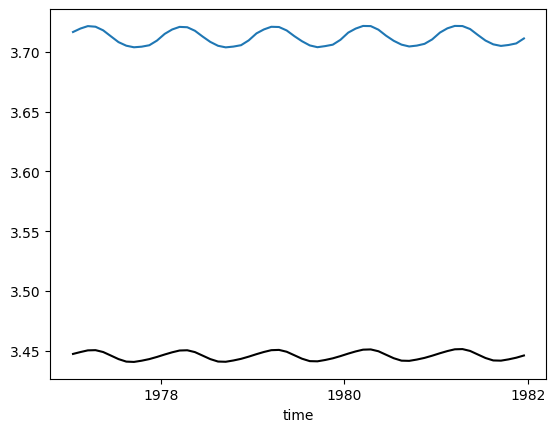

In [198]:
thetao_3d.plot(color='k')
thetao_coarse_3d.plot(color='tab:blue')

## Global integral is different. To be fixed later

In [199]:
(thetao * param.dxt * param.dyt)[0][0].sum().values# / (xr.where(np.isnan(thetao),np.nan,1.) * param.dxt * param.dyt)[0][0].sum().values

array(6.618872e+15, dtype=float32)

In [202]:
(regrid(thetao) * param_coarse.dxt * param_coarse.dyt)[0][0].sum().values# / (xr.where(np.isnan(regrid(thetao)),np.nan,1.) * param_coarse.dxt * param_coarse.dyt)[0][0].sum().values

array(5.65698697e+15)

# Snapshots

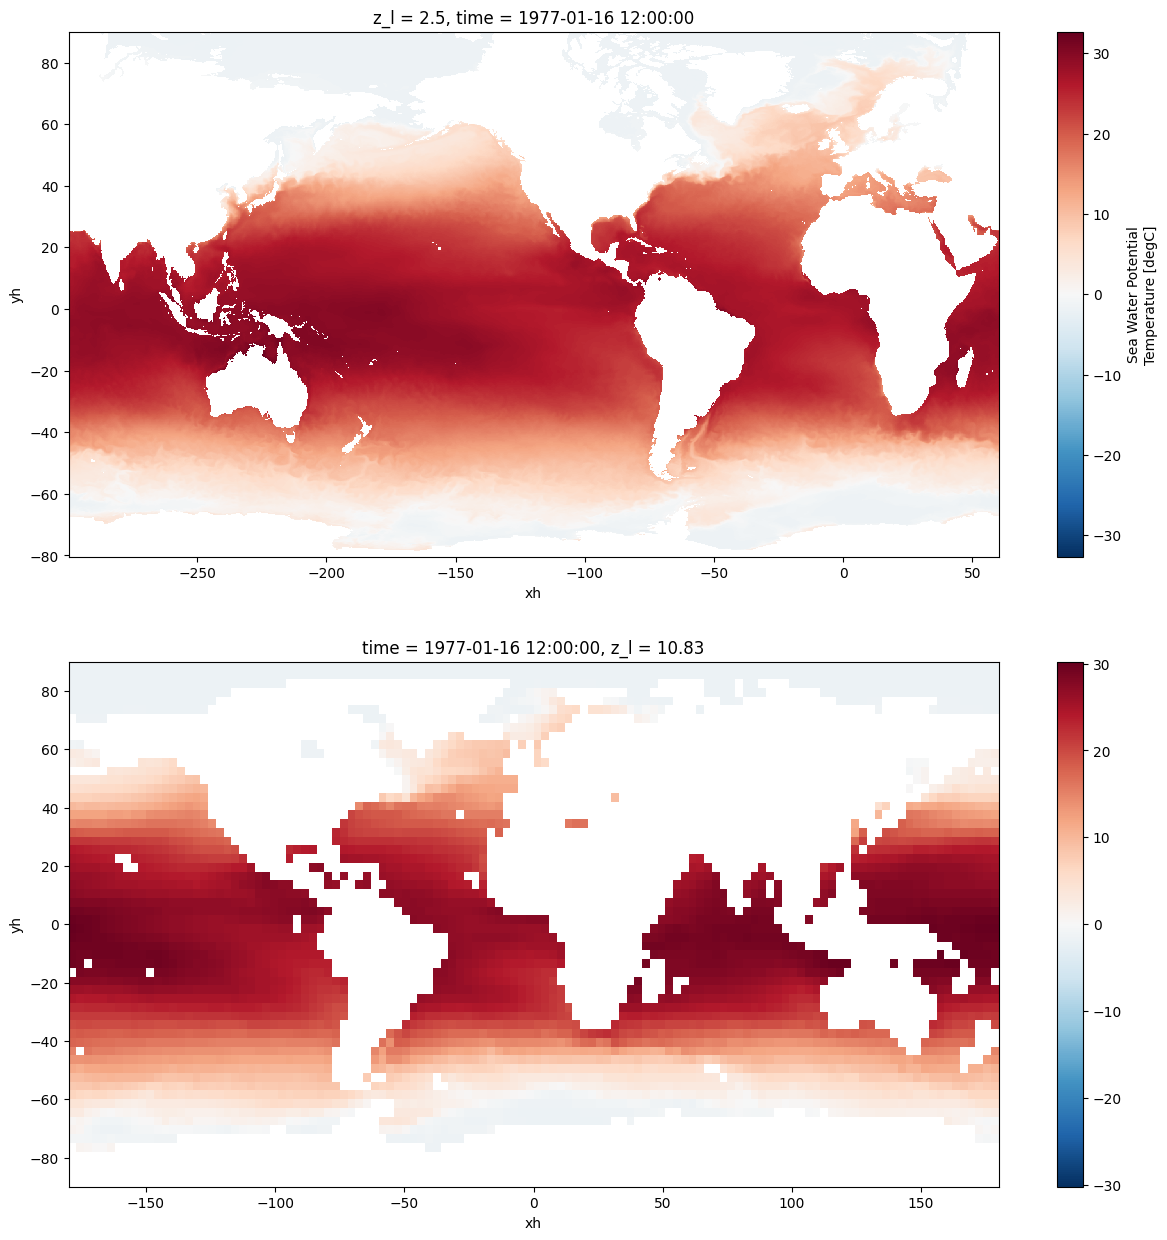

In [205]:
plt.figure(figsize=(15,15))

plt.subplot(2,1,1)
thetao[0][0].plot()

plt.subplot(2,1,2)
thetao_coarse[0][0].plot()

# Coarsegraing all available data

In [209]:
base_path = '/scratch/pp2681/mom6/OM4_SIS2/'
for exp in ['unparameterized', 'unparameterized-0.03', 'unparameterized-0.09',
            'JHAH15', 'GM', 'vert-diff',
            'ZB20-Klower', 'ZB20-Reynolds', 'ZB20-Smooth-1.0', 'ZB20-Smooth-2.5',
            'ANN-greenline', 'ANN-redline', 'ANN-FGR-2', 'ANN-Taper', 'ANN-strain',
            'ANN-1x1', 'ANN-3x3-32-32', 'ANN-3x3-EXP2', 'ANN-5x5-Klower']:
    files = os.path.join(base_path,exp,'output','*ocean_month_z*')
    ds = xr.open_mfdataset(files, chunks={'time':1})
    
    thetao = ds.thetao
    # Vertical coarsening
    param['dz'] = xr.DataArray(np.diff(ds.z_i), dims='z_l')
    param['mask_nan'] = xr.where(np.isnan(thetao.isel(time=0)),np.nan,1.)
    thetao_coarse_vertical = ((param['dz']* thetao).coarsen({'z_l':3}, boundary='trim').sum() / (param['dz'] * param['mask_nan']).coarsen({'z_l':3}, boundary='trim').sum()).transpose('time','z_l',...)
    # Horizontal coarsening
    thetao_coarse = regrid(thetao_coarse_vertical)

    ds_coarse = xr.Dataset()
    ds_coarse['thetao'] = thetao_coarse
    with ProgressBar():
        ds_coarse.to_netcdf(os.path.join('/scratch/pp2681/calibration/OM4-NIF-5-years', f'{exp}.nc'))
    print(f'{exp} is finished')

[########################################] | 100% Completed | 31.08 s
unparameterized is finished
[########################################] | 100% Completed | 31.21 s
unparameterized-0.03 is finished
[########################################] | 100% Completed | 31.99 s
unparameterized-0.09 is finished
[########################################] | 100% Completed | 31.19 s
JHAH15 is finished
[########################################] | 100% Completed | 31.30 s
GM is finished
[########################################] | 100% Completed | 31.91 s
vert-diff is finished
[########################################] | 100% Completed | 32.11 s
ZB20-Klower is finished
[########################################] | 100% Completed | 34.20 s
ZB20-Reynolds is finished
[########################################] | 100% Completed | 32.69 s
ZB20-Smooth-1.0 is finished
[########################################] | 100% Completed | 33.01 s
ZB20-Smooth-2.5 is finished
[########################################] |

In [8]:
base_path = '/scratch/js15017/OM4_storage/CORE-AIF-runs'
for exp in ['unparameterized', 'ZB20', 'ANN', 'MEKE-Chang']:
    files = os.path.join(base_path,exp,'*ocean_annual_z*')
    ds = xr.open_mfdataset(files, parallel=True, combine='nested', compat='no_conflicts', concat_dim='time', chunks={'time':1})
    
    thetao = ds.thetao
    # Vertical coarsening
    param['dz'] = xr.DataArray(np.diff(ds.z_i), dims='z_l')
    param['mask_nan'] = xr.where(np.isnan(thetao.isel(time=0)),np.nan,1.)
    thetao_coarse_vertical = ((param['dz']* thetao).coarsen({'z_l':3}, boundary='trim').sum() / (param['dz'] * param['mask_nan']).coarsen({'z_l':3}, boundary='trim').sum()).transpose('time','z_l',...)
    # Horizontal coarsening
    thetao_coarse = regrid(thetao_coarse_vertical)

    ds_coarse = xr.Dataset()
    ds_coarse['thetao'] = thetao_coarse
    with ProgressBar():
        ds_coarse.to_netcdf(os.path.join('/scratch/pp2681/calibration/OM4-AIF-60-years', f'{exp}.nc'))
    print(f'{exp} is finished')

[########################################] | 100% Completed | 42.85 s
unparameterized is finished
[########################################] | 100% Completed | 48.99 s
ZB20 is finished
[########################################] | 100% Completed | 46.55 s
ANN is finished
[########################################] | 100% Completed | 47.17 s
MEKE-Chang is finished


# Check precomuted data

In [213]:
def read_data(exp='unparameterized'):
    return xr.open_dataset(os.path.join('/scratch/pp2681/calibration/OM4-NIF-5-years', f'{exp}.nc')).thetao

In [221]:
def ave3d(array, param):
    return (array * param.dxt * param.dyt * param.dz * param.mask_nan).sum(['xh','yh','z_l']) / (param.dxt * param.dyt * param.dz * param.mask_nan).sum(['xh','yh','z_l'])

In [222]:
param = xr.open_dataset('/scratch/pp2681/calibration/OM4-NIF-5-years/param.nc')

In [235]:
ann = ave3d(read_data('ANN-greenline'), param)
gm = ave3d(read_data('GM'), param)
control = ave3d(read_data(), param)

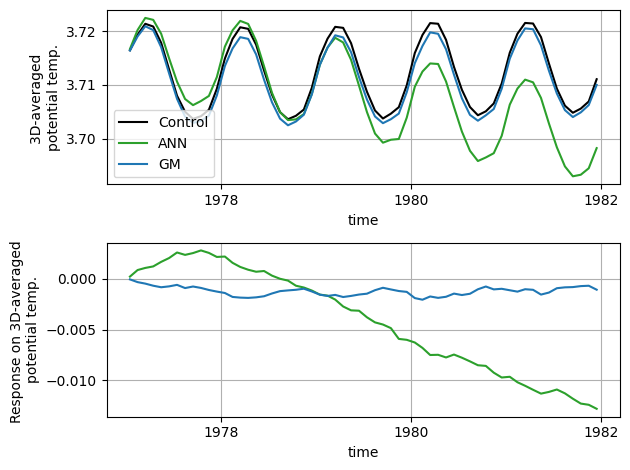

In [243]:
plt.subplot(2,1,1)
control.plot(color='k', label='Control')
ann.plot(color='tab:green', label='ANN')
gm.plot(color='tab:blue', label='GM')
plt.legend()
plt.ylabel('3D-averaged \npotential temp.')
plt.grid()
plt.subplot(2,1,2)
(ann-control).plot(color='tab:green', label='ANN')
(gm-control).plot(color='tab:blue', label='GM')
plt.grid()
plt.ylabel('Response on 3D-averaged \npotential temp.')

plt.tight_layout()

# Different coarsegraining
Here we apply spatial coarsegraining to CMIP6 domains and introduce only three layers of ocean: 0m-100m, 100m-1000m, 1000m-bottom.

Horiziontal decomposition into domains allows to track heating in different ocean basins. Additionally, three vertical layers account for major places where responses are observed. The upper ocean (0m-100m) responds very fast, but it is heavily constrained by the boundary condition. Medium depth (100m-1000m) is where most of the response is concentrated. Finally, deep water (1000m-bottom) almost does not respond to different parameterizations.

Our decomposition is a cartesian product of horizontal and vertical subdomains. Consequently, for every coarse 3d subdomain we can assign the mean value. We denote the 3d subdomain as $D_{ik}$, where $i$ is the index of horizontal subdomain ($\approx 10$ in total), and $k$ is the vertical index ($3$ in total). The mean value in subdomain is thus given as:
$$
T_{ik} = \frac{1}{V_{ik}}\sum_{x,y,z \in D_{ik} } T(x,y,z) V(x,y,z),
$$
here $T(x,y,z)$ is the potential temperature in grid point with horizontal coordinates $x,y$ and vertical coordinate $z$, $V(x,y,z)$ is the volume of the grid cell multiplied by the mask of grid cells (i.e., volume in land is zero).
Finally, 
$$
V_{ik} = \sum_{x,y,z \in D_{ik} } V(x,y,z).
$$

We wish our coarsegraining procedure be conservative in the following sense. First we want to keep the same global average value, that is:
$$
\frac{1}{V} \sum_{x,y,z} T(x,y,z) V(x,y,z) = \frac{1}{V} \sum_{ik} T_{ik} V_{ik},
$$
where
$$
V = \sum_{x,y,z} V(x,y,z) \equiv \sum_{ik} V_{ik}.
$$
Both properties are satisfied if subdomains $D_{ik}$ constitute a partition of the full set of grid points, that is:
$$
\sum_{x,y,z} V(x,y,z) = \sum_{ik} \sum_{x,y,z \in D_{ik}} V(x,y,z).
$$

# Horizontal decomposition
We have in total 10 unique codes in CMIP6. We obtaing time series for all of them. However, we note that the first five codes (1-5) represent five oceans and have a predominants importance. Another 5 codes (6-10) represent regional seas and can be avoided for reduced order model.

In [8]:
from cmip_basins import generate_basin_codes

In [9]:
basincodes = generate_basin_codes(param, lon='geolon', lat='geolat', mask='wet')

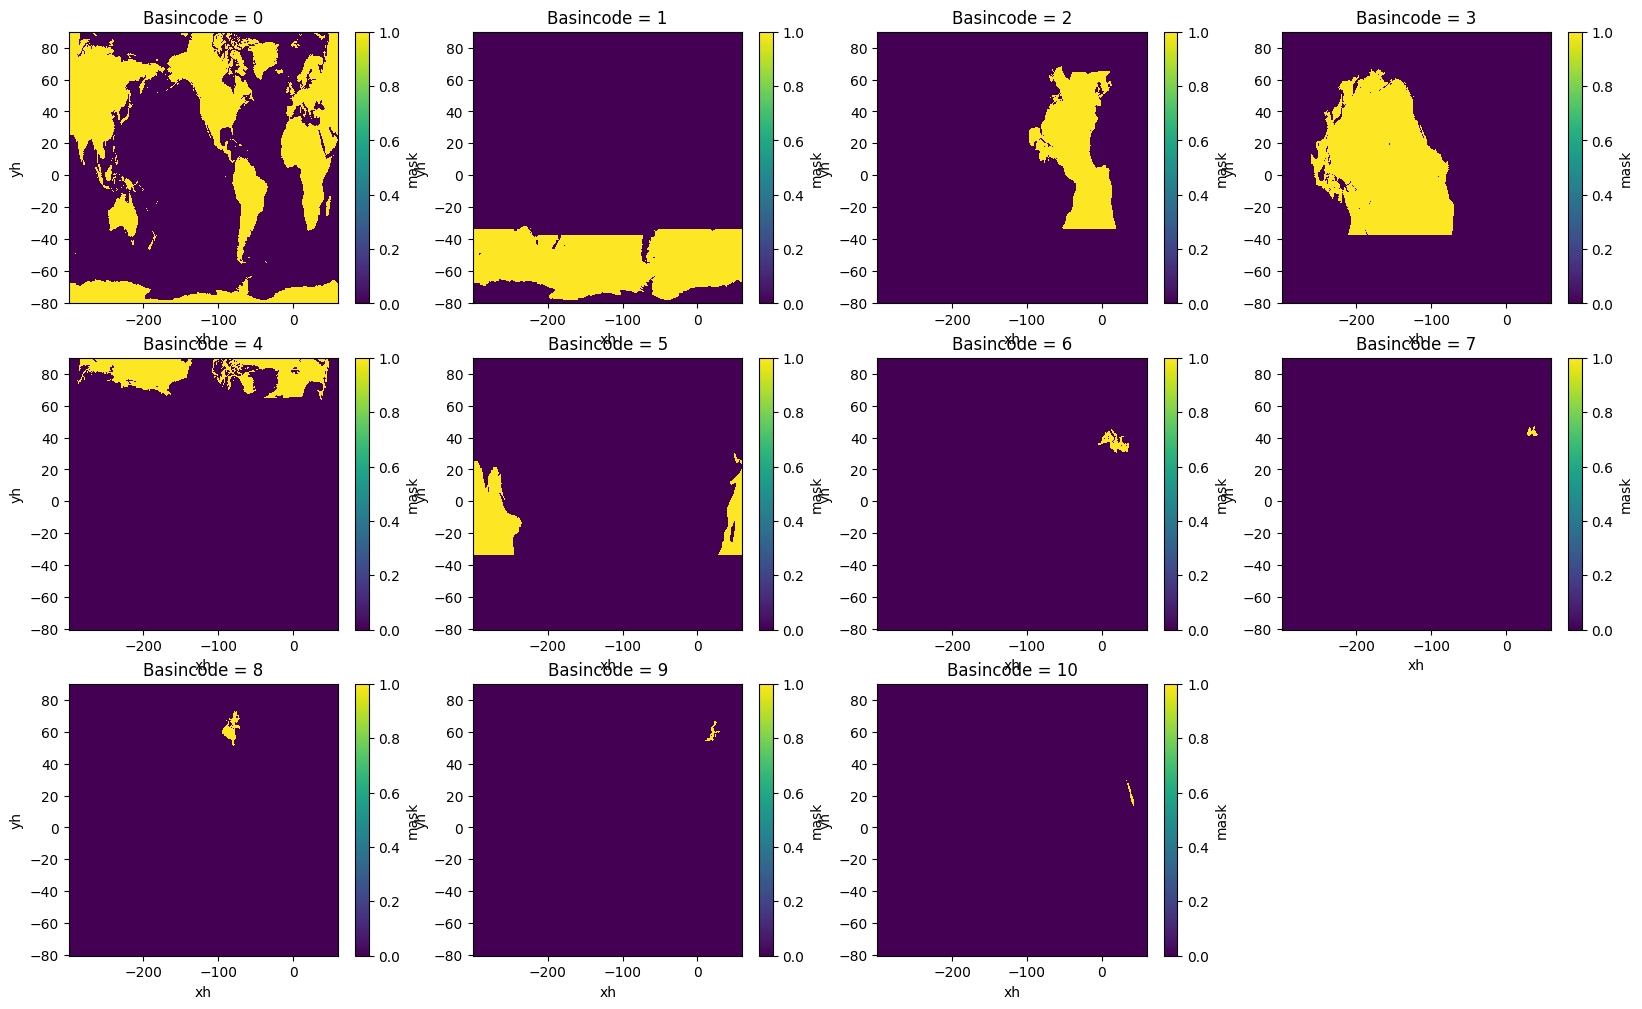

In [23]:
plt.figure(figsize=(20,12))
for i in range(11):
    plt.subplot(3,4,i+1)
    (basincodes==i).plot()
    plt.title(f'Basincode = {i}')

In [57]:
print((basincodes>0).sum().data)
print((param.wet>0).sum().data)

969446
969446


# Vertical coarsegraining
We introduce two boundaries between three layers. First boundary is approximately 100m and second is approximately 1000m. We choose boundaries to minimize the reconstruction error. 

In [33]:
base_path = '/scratch/js15017/OM4_storage/CORE-AIF-runs'
files = os.path.join(base_path,'unparameterized','*ocean_annual_z*')
control = xr.open_mfdataset(files, parallel=True, combine='nested', compat='no_conflicts', concat_dim='time', chunks={'time':1})

files = os.path.join(base_path,'ANN','*ocean_annual_z*')
ann = xr.open_mfdataset(files, parallel=True, combine='nested', compat='no_conflicts', concat_dim='time', chunks={'time':1})

In [34]:
def ave2d(array, param):
    return (array * param.dxt * param.dyt * param.mask_nan).sum(['xh','yh']) / (param.dxt * param.dyt * param.mask_nan).sum(['xh','yh'])

In [129]:
param['mask_nan'] = xr.where(np.isnan(thetao.isel(time=0)),np.nan,1.)
param['dz'] = xr.DataArray(np.diff(ds.z_i), dims='z_l', coords={'z_l': ds.z_l})
param['z_i'] = ds.z_i

In [38]:
with ProgressBar():
    response = ave2d(ann.thetao - control.thetao, param).compute()

[########################################] | 100% Completed | 125.17 s


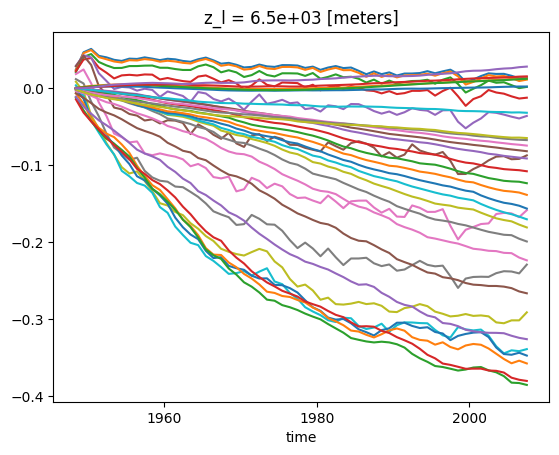

In [41]:
for z_l in range(35):
    response[:,z_l].plot()

In [131]:
best_error = 1e+10
best_upper = 0
best_lower = 0
for upper_border in range(1,34):
    for lower_border in range(upper_border+1,34):
        response_srf = (param.dz * response).isel(z_l=slice(None,upper_border)).mean('z_l') / (param.dz)[:upper_border].mean('z_l')
        response_mid = (param.dz * response).isel(z_l=slice(upper_border,lower_border)).mean('z_l') / (param.dz)[upper_border:lower_border].mean('z_l')
        response_bot = (param.dz * response).isel(z_l=slice(lower_border,None)).mean('z_l') / (param.dz)[lower_border:].mean('z_l')

        reconstruction_error = np.sqrt(((response.isel(z_l=slice(None,upper_border)) - response_srf)**2 * param.dz).sum('z_l') + \
                               ((response.isel(z_l=slice(upper_border,lower_border)) - response_mid)**2 * param.dz).sum('z_l') + \
                               ((response.isel(z_l=slice(lower_border,None)) - response_bot)**2 * param.dz).sum('z_l')).mean('time').values
        print(f'upper_border={upper_border}, lower_border={lower_border}, error={reconstruction_error}')
        if reconstruction_error < best_error:
            best_error = reconstruction_error
            best_upper = upper_border
            best_lower = lower_border
print('\nBest combination: \n')
print(f'upper_border={best_upper}, lower_border={best_lower}, error={best_error}')

upper_border=1, lower_border=2, error=5.422666126776261
upper_border=1, lower_border=3, error=5.418591338073275
upper_border=1, lower_border=4, error=5.414824191862122
upper_border=1, lower_border=5, error=5.413291316322176
upper_border=1, lower_border=6, error=5.41764282524787
upper_border=1, lower_border=7, error=5.421888113844431
upper_border=1, lower_border=8, error=5.414268336940192
upper_border=1, lower_border=9, error=5.366733583262183
upper_border=1, lower_border=10, error=5.247649328124368
upper_border=1, lower_border=11, error=5.097823840195511
upper_border=1, lower_border=12, error=4.825974669023533
upper_border=1, lower_border=13, error=4.34859742720383
upper_border=1, lower_border=14, error=3.817995511749816
upper_border=1, lower_border=15, error=3.40823735273141
upper_border=1, lower_border=16, error=3.2004451292635543
upper_border=1, lower_border=17, error=3.1468260863173247
upper_border=1, lower_border=18, error=3.1525398204118913
upper_border=1, lower_border=19, error=

In [94]:
print(response.z_l[:7].values)
print(response.z_l[7:19].values)

[  2.5   10.    20.    32.5   51.25  75.   100.  ]
[ 125.    156.25  200.    250.    312.5   400.    500.    600.    700.
  800.    900.   1000.  ]


In [137]:
print(response.z_l[:16].values)
print(response.z_l[16:29].values)
print(response.z_l[29:].values)

[  2.5   10.    20.    32.5   51.25  75.   100.   125.   156.25 200.
 250.   312.5  400.   500.   600.   700.  ]
[ 800.   900.  1000.  1100.  1200.  1300.  1400.  1537.5 1750.  2062.5
 2500.  3000.  3500. ]
[4000. 4500. 5000. 5500. 6000. 6500.]


# Analysis of vertical decomposition
Intuitive decomposition (100m and 1000m) extracts mixed layer, middle ocean and bottom ocean
Data-driven decomposition, instead, (700m and 3500m), extracts upper ocean pattern of strong cooling, middle ocean slow cooling and deep ocean heating. As data-driven decomposition provides better reconstruction, we choose it below.

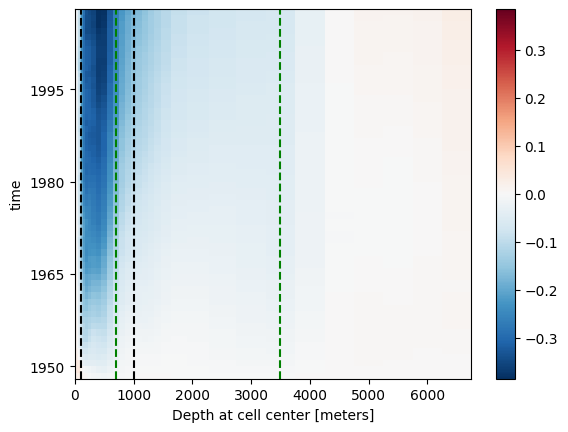

In [101]:
response.plot()
plt.axvline(x=100, color='k', linewidth=1.5, ls='--')
plt.axvline(x=1000, color='k', linewidth=1.5, ls='--')

plt.axvline(x=700, color='g', linewidth=1.5, ls='--')
plt.axvline(x=3500, color='g', linewidth=1.5, ls='--')

# Averaging data

In [2]:
exp = 'unparameterized'
base_path = '/scratch/js15017/OM4_storage/CORE-AIF-runs'
files = os.path.join(base_path,exp,'*ocean_annual_z*')
ds = xr.open_mfdataset(files, parallel=True, combine='nested', compat='no_conflicts', concat_dim='time', chunks={'time':1}).sortby('time')
thetao = ds.thetao

In [3]:
from cmip_basins import generate_basin_codes
param = xr.open_dataset('/home/pp2681/global-runs/data/ocean_static.nc').isel(time=0)
param['basincodes'] = generate_basin_codes(param, lon='geolon', lat='geolat', mask='wet').compute()
param['dz'] = xr.DataArray(np.diff(ds.z_i), dims='z_l')
param['mask_nan'] = xr.where(np.isnan(thetao.isel(time=0)),np.nan,1.)

In [4]:
%%time
thetao_srf = (thetao.isel(z_l=slice(None,16)) * param.dz).sum('z_l').compute()
thetao_mid = (thetao.isel(z_l=slice(16,29)) * param.dz).sum('z_l').compute()
thetao_bot = (thetao.isel(z_l=slice(29,None)) * param.dz).sum('z_l').compute()

CPU times: user 1min 25s, sys: 49.1 s, total: 2min 15s
Wall time: 1min 40s


In [5]:
%%time
dz_srf = (param.mask_nan.isel(z_l=slice(None,16)) * param.dz).sum('z_l').compute()
dz_mid = (param.mask_nan.isel(z_l=slice(16,29)) * param.dz).sum('z_l').compute()
dz_bot = (param.mask_nan.isel(z_l=slice(29,None)) * param.dz).sum('z_l').compute()

CPU times: user 1.78 s, sys: 1.11 s, total: 2.89 s
Wall time: 2.93 s


In [6]:
dS = (param.dxt * param.dyt).compute()

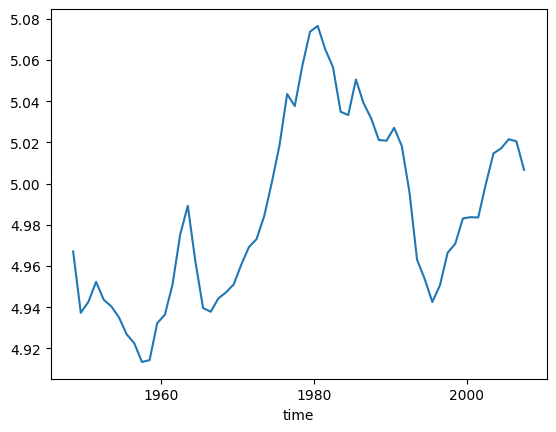

In [7]:
mask = (param.basincodes==1)
((thetao_srf * dS).where(mask).sum(['xh','yh']) / (dz_srf * dS).where(mask).sum(['xh','yh'])).plot()

In [11]:
%%time
import dask.array as da
# Note here we define the vertical coordinate values approximately for ease of explanation
ds_coarse = xr.Dataset()
depth_coord = xr.DataArray([350., 2000., 5000.], dims='depth')
ds_coarse['thetao'] = xr.DataArray(np.zeros((60,3,11))*np.nan, dims=['time', 'depth', 'code'], coords={'depth': depth_coord, 'time':thetao.time})
ds_coarse['volume'] = xr.DataArray(np.zeros((3,11))*np.nan, dims=['depth', 'code'], coords={'depth': depth_coord})

dS = (param.dxt * param.dyt).compute()

for code in range(0,11):
    mask = (param.basincodes==code)
    volume_srf = (dz_srf * dS).where(mask).sum()
    ds_coarse['volume'][{'code':code, 'depth': 0}] = volume_srf
    ds_coarse['thetao'][{'code':code, 'depth': 0}] = (thetao_srf * dS).where(mask).sum(['xh','yh']) / volume_srf

    volume_mid = (dz_mid * dS).where(mask).sum()
    ds_coarse['volume'][{'code':code, 'depth': 1}] = volume_mid
    ds_coarse['thetao'][{'code':code, 'depth': 1}] = (thetao_mid * dS).where(mask).sum(['xh','yh']) / volume_mid

    volume_bot = (dz_bot * dS).where(mask).sum()
    ds_coarse['volume'][{'code':code, 'depth': 2}] = volume_bot
    ds_coarse['thetao'][{'code':code, 'depth': 2}] = (thetao_bot * dS).where(mask).sum(['xh','yh']) / volume_bot

ds_coarse = ds_coarse.transpose('time', 'code', 'depth')

CPU times: user 22.1 s, sys: 18.2 s, total: 40.3 s
Wall time: 40.5 s


# Test conservation

In [12]:
print(ds_coarse.volume.sum().values)
print((param.dxt * param.dyt * param.dz * param.mask_nan).sum().values)

1.4142831364829962e+18
1.4142831364829937e+18


In [61]:
T3d_coarse = (ds_coarse.volume * ds_coarse.thetao).sum(['code','depth']) / (ds_coarse.volume).sum(['code','depth'])

In [65]:
T3d_coarse_oceans = (ds_coarse.volume * ds_coarse.thetao).isel(code=slice(1,6)).sum(['code','depth']) / (ds_coarse.volume).isel(code=slice(1,6)).sum(['code','depth'])

In [64]:
T3d = ave3d(thetao, param).compute()

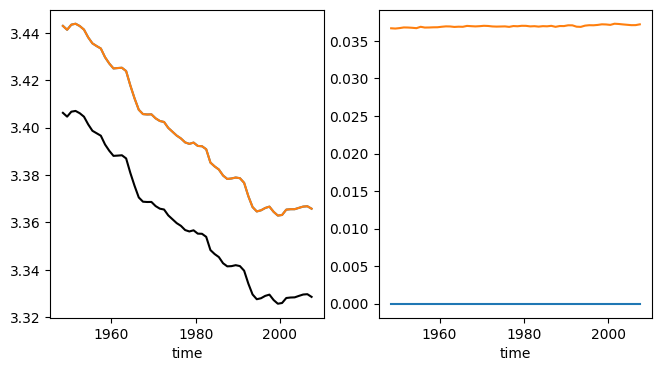

In [69]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
T3d.plot()
T3d_coarse.plot()
T3d_coarse_oceans.plot(color='k')
plt.subplot(1,3,2)
(T3d-T3d_coarse).plot()

plt.subplot(1,3,2)
(T3d-T3d_coarse_oceans).plot()

# Compute dataset

In [155]:
from cmip_basins import generate_basin_codes
param = xr.open_dataset('/home/pp2681/global-runs/data/ocean_static.nc').isel(time=0)
param['basincodes'] = generate_basin_codes(param, lon='geolon', lat='geolat', mask='wet').compute()
param['dz'] = xr.DataArray(np.diff(ds.z_i), dims='z_l')
param['mask_nan'] = xr.where(np.isnan(thetao.isel(time=0)),np.nan,1.)

In [158]:
%%time 

base_path = '/scratch/js15017/OM4_storage/CORE-AIF-runs'
for exp in ['unparameterized', 'ZB20', 'ANN', 'MEKE-Chang']:
    files = os.path.join(base_path,exp,'*ocean_annual_z*')
    ds = xr.open_mfdataset(files, parallel=True, combine='nested', compat='no_conflicts', concat_dim='time', chunks={'time':1}).sortby('time')
    
    thetao = ds.thetao

    thetao_srf = (thetao.isel(z_l=slice(None,16)) * param.dz).sum('z_l').compute()
    thetao_mid = (thetao.isel(z_l=slice(16,29)) * param.dz).sum('z_l').compute()
    thetao_bot = (thetao.isel(z_l=slice(29,None)) * param.dz).sum('z_l').compute()

    dz_srf = (param.mask_nan.isel(z_l=slice(None,16)) * param.dz).sum('z_l').compute()
    dz_mid = (param.mask_nan.isel(z_l=slice(16,29)) * param.dz).sum('z_l').compute()
    dz_bot = (param.mask_nan.isel(z_l=slice(29,None)) * param.dz).sum('z_l').compute()

    dS = (param.dxt * param.dyt).compute()

    ds_coarse = xr.Dataset()
    depth_coord = xr.DataArray([350., 2000., 5000.], dims='depth')
    code_coord = xr.DataArray(np.arange(0,11), dims='code')
    ds_coarse['thetao'] = xr.DataArray(np.zeros((60,3,11))*np.nan, dims=['time', 'depth', 'code'], coords={'depth': depth_coord, 'time':thetao.time, 'code': code_coord})
    ds_coarse['volume'] = xr.DataArray(np.zeros((3,11))*np.nan, dims=['depth', 'code'], coords={'depth': depth_coord, 'code': code_coord})

    for code in range(0,11):
        mask = (param.basincodes==code)
        volume_srf = (dz_srf * dS).where(mask).sum()
        ds_coarse['volume'][{'code':code, 'depth': 0}] = volume_srf
        ds_coarse['thetao'][{'code':code, 'depth': 0}] = (thetao_srf * dS).where(mask).sum(['xh','yh']) / volume_srf
    
        volume_mid = (dz_mid * dS).where(mask).sum()
        ds_coarse['volume'][{'code':code, 'depth': 1}] = volume_mid
        ds_coarse['thetao'][{'code':code, 'depth': 1}] = (thetao_mid * dS).where(mask).sum(['xh','yh']) / volume_mid
    
        volume_bot = (dz_bot * dS).where(mask).sum()
        ds_coarse['volume'][{'code':code, 'depth': 2}] = volume_bot
        ds_coarse['thetao'][{'code':code, 'depth': 2}] = (thetao_bot * dS).where(mask).sum(['xh','yh']) / volume_bot
    
    ds_coarse = ds_coarse.transpose('time', 'code', 'depth')

    ds_coarse.to_netcdf(f'/scratch/pp2681/calibration/OM4-AIF/basins/{exp}.nc')
    print(f'{exp} is done')

unparameterized is done
ZB20 is done
ANN is done
MEKE-Chang is done
CPU times: user 7min 27s, sys: 4min 39s, total: 12min 6s
Wall time: 10min 21s


In [159]:
param.to_netcdf('/scratch/pp2681/calibration/OM4-AIF/basins/param.nc')

# Check data. Analyze responses in 1981-2007 means

In [162]:
def read_data(exp='unparameterized'):
    out = xr.open_dataset(f'/scratch/pp2681/calibration/OM4-AIF/basins/{exp}.nc').sel(time=slice('1981',None)).thetao.mean('time')
    return out[1:6]

In [163]:
def plot_metric(data, yticks=True):
    im = data.drop_vars(['depth','code']).plot(add_colorbar=False, vmin=-1)
    plt.xticks([0,1,2],[350,2000,5000])
    plt.xlabel('Depth [m]')
    if yticks:
        plt.yticks([0,1,2,3,4], ['Southern', 'Atlantic', 'Pacific', 'Arctic', 'Indian'])
    else:
        plt.yticks([0,1,2,3,4], ['']*5)
    plt.title('ANN-Control')
    plt.ylabel('')

    # Add text annotations
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            plt.text(j, i, "%.2f" % float(data[i,j]),
                    ha='center', va='center', color='k', fontsize=10)

    return im

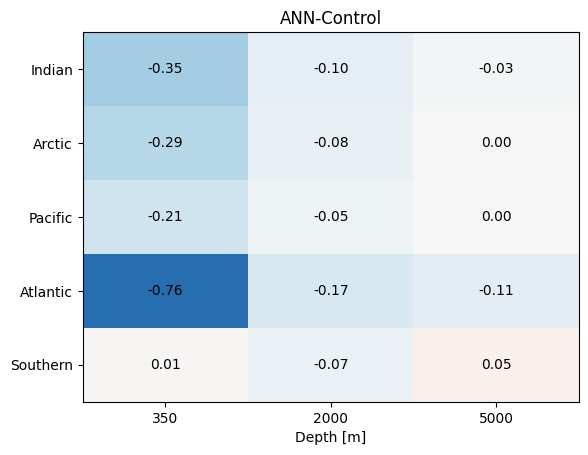

In [164]:
plot_metric(read_data('ANN') - read_data('unparameterized'))

Text(0.5, 1.05, 'Response in potential temperature\naveraged over 1981-2007')

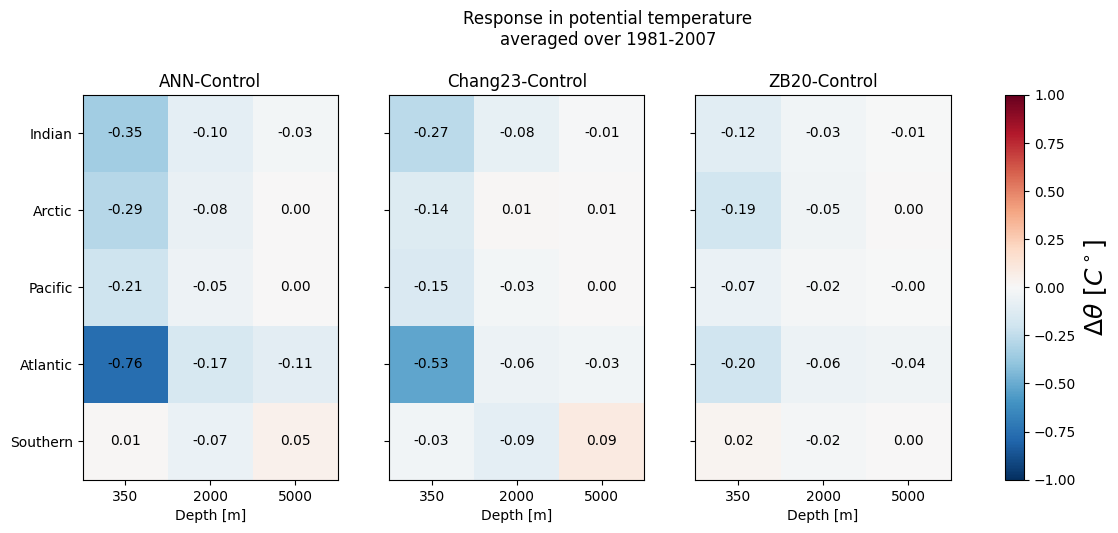

In [165]:
plt.figure(figsize=(14,5))
plt.subplot(1,3,1)
im = plot_metric(read_data('ANN') - read_data('unparameterized'))
plt.title('ANN-Control')

plt.subplot(1,3,2)
plot_metric(read_data('MEKE-Chang') - read_data('unparameterized'), yticks=False)
plt.title('Chang23-Control')

plt.subplot(1,3,3)
plot_metric(read_data('ZB20') - read_data('unparameterized'), yticks=False)
plt.title('ZB20-Control')

cbar = plt.colorbar(im,ax=plt.gcf().axes)
cbar.set_label('$\Delta \\theta$ [$C^\circ$]', fontsize=18)
plt.suptitle('Response in potential temperature\naveraged over 1981-2007', y=1.05)

#plt.tight_layout()